# Abalone Rings Regressoin using LSTM

## Method 1: Considering each data sample as a item in a sequence

In [23]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [24]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [15]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [17]:
class AbaloneSequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=5):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [18]:
train_dataset = AbaloneSequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneSequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneSequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class AbaloneLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AbaloneLSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 2
net = AbaloneLSTMRegressor(X.shape[1], hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [21]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        train_total += labels.size(0)
    train_losses.append(train_loss / train_total)

    net.eval()
    val_loss = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch [10/50], Train Loss: 10.2810, Validation Loss: 11.3884
Epoch [20/50], Train Loss: 6.7665, Validation Loss: 7.4840
Epoch [30/50], Train Loss: 5.1456, Validation Loss: 5.5643
Epoch [40/50], Train Loss: 4.5477, Validation Loss: 5.1492
Epoch [50/50], Train Loss: 4.3397, Validation Loss: 4.7899


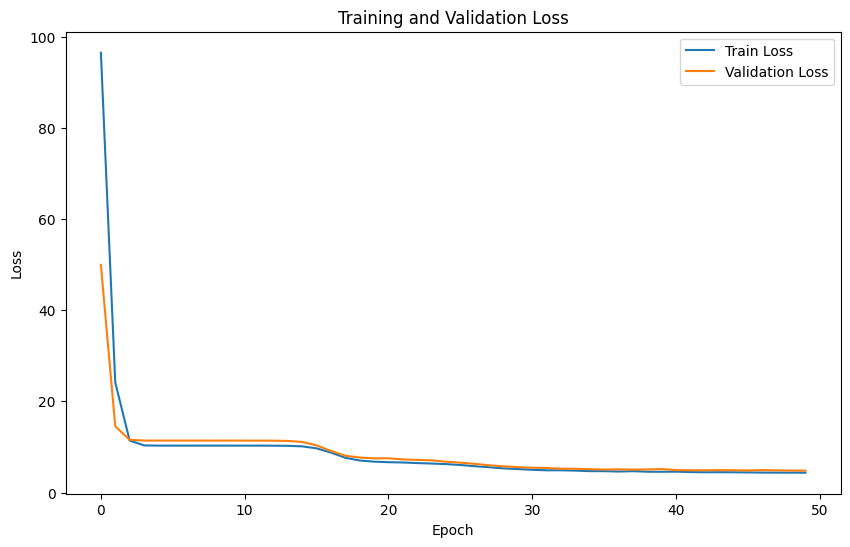

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [25]:
test_mae = 0
test_mse = 0
test_r2 = 0

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        running_mae = mean_absolute_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_mse = mean_squared_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_r2 = r2_score(labels.cpu().numpy(), outputs.cpu().numpy())

        test_mae += running_mae * labels.size(0)
        test_mse += running_mse * labels.size(0)
        test_r2 += running_r2 * labels.size(0)

test_mae /= len(test_loader.dataset)
test_mse /= len(test_loader.dataset)
test_r2 /= len(test_loader.dataset)

print('Final Results:')
print(f'\tMean Absolute Error: {test_mae:.4f}')
print(f'\tMean Squared Error: {test_mse:.4f}')
print(f'\tr2 Score: {test_r2:.4f}')

Final Results:
	Mean Absolute Error: 1.5709
	Mean Squared Error: 4.7041
	r2 Score: 0.5093


## Method 2: Considering each feature in a data sample as a item in a sequence

In [12]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [13]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [14]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [16]:
class AbaloneSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = AbaloneSequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneSequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneSequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
class AbaloneLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AbaloneLSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 2
net = AbaloneLSTMRegressor(X.shape[1], hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        train_total += labels.size(0)
    train_losses.append(train_loss / train_total)

    net.eval()
    val_loss = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs.unsqueeze(1))
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch [10/100], Train Loss: 6.1822, Validation Loss: 6.7417
Epoch [20/100], Train Loss: 5.1947, Validation Loss: 5.6604
Epoch [30/100], Train Loss: 4.7338, Validation Loss: 5.1100
Epoch [40/100], Train Loss: 4.5648, Validation Loss: 4.8115
Epoch [50/100], Train Loss: 4.4205, Validation Loss: 4.6778
Epoch [60/100], Train Loss: 4.3254, Validation Loss: 4.4542
Epoch [70/100], Train Loss: 4.2580, Validation Loss: 4.3495
Epoch [80/100], Train Loss: 4.2004, Validation Loss: 4.3183
Epoch [90/100], Train Loss: 4.2370, Validation Loss: 4.2964
Epoch [100/100], Train Loss: 4.1757, Validation Loss: 4.2675


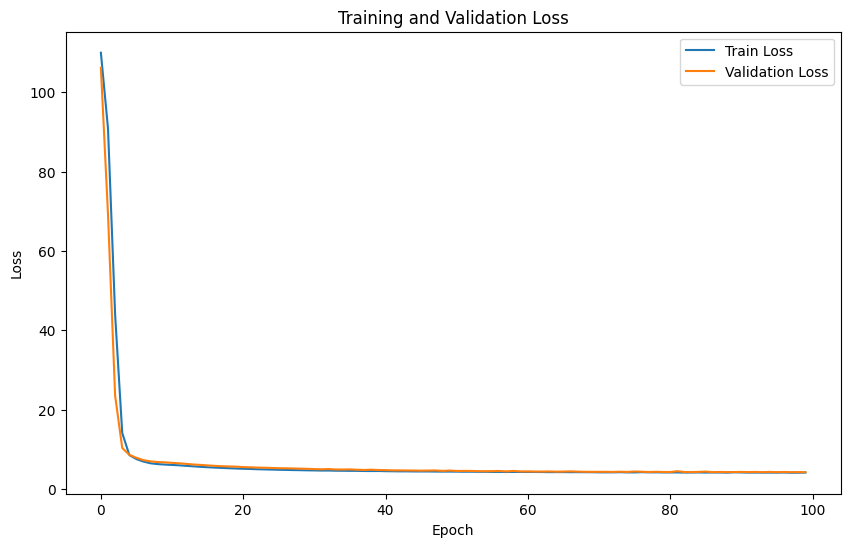

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [22]:
test_mae = 0
test_mse = 0
test_r2 = 0

net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs.unsqueeze(1))

        running_mae = mean_absolute_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_mse = mean_squared_error(labels.cpu().numpy(), outputs.cpu().numpy())
        running_r2 = r2_score(labels.cpu().numpy(), outputs.cpu().numpy())

        test_mae += running_mae * labels.size(0)
        test_mse += running_mse * labels.size(0)
        test_r2 += running_r2 * labels.size(0)

test_mae /= len(test_loader.dataset)
test_mse /= len(test_loader.dataset)
test_r2 /= len(test_loader.dataset)

print('Final Results:')
print(f'\tMean Absolute Error: {test_mae:.4f}')
print(f'\tMean Squared Error: {test_mse:.4f}')
print(f'\tr2 Score: {test_r2:.4f}')

Final Results:
	Mean Absolute Error: 1.4754
	Mean Squared Error: 4.3366
	r2 Score: 0.5472
